# The goal of the project
### Based on analytic data on customers profiles and interactions collected by the gym chain Model Fitness, to analyze customer profiles and, on their basis, think over a customer retention strategy. Additional tasks of this project are drawing up a typical user profile, analyzing the factors affecting churn, and making recommendations for customer service.

In [1]:
!pip install scikit-plot

In [2]:
import pandas as pd

from scipy import stats
import numpy as np
from numpy import unique
from numpy import where
import math

from io import BytesIO
import requests

import datetime
from datetime import datetime

from plotly import express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.offline as pyoff
import plotly as py
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

## Step 1. Open the data file and study general information

In [3]:
spreadsheet_id = '1Qjn9omuF1D6NmVtjMPv_eMg9Y5qnSwvsN4RCozyMMlY'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
mf = pd.read_csv(BytesIO(r.content))

In [4]:
#mf = pd.read_csv('/datasets/gym_churn_us.csv')

print(mf.shape)
mf.info()

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

In [5]:
mf.columns= mf.columns.str.lower()
mf.month_to_end_contract = mf.month_to_end_contract.astype('int')
mf.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [6]:
mf.duplicated().sum()

0

### Conclusion

On this step of the project we have opened and studied the data on customers by the gym chain Model Fitness. The data looks good, there are no missing values, we only changed the data type of the column 'month_to_end_contract' to integer and changed the names of all columns to lowercase for more convenient work with the data.  
Checking the data for duplicates did not reveal duplicate values.

## Step 2. Carry out exploratory data analysis (EDA)

### Descriptive analytics

In [7]:
#splitting the columns into Categorical and Numerical columns

target_col = 'churn'
num_cols = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
cat_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']
mf_num = mf[num_cols]
# spliting categorical columns into Nominal and Binary columns
nominal_cols = ['contract_period']
binary_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

In [8]:
mf[cat_cols].describe(include='all')

,gender,near_location,partner,promo_friends,phone,group_visits,contract_period
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,0.412250,4.681250
std,0.499957,0.361711,0.499887,0.461932,0.295313,0.492301,4.549706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


In [9]:
mf[num_cols].describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


According to the results above I can draw some conclusions. First of all, we need to check numerical columns with outliers. Also I want to note the average of the column 'near location' is quite high (0.84).  
On this step we can describe the typical client of the gym chain Model Fitness. The main indicator is the near location of the gym to the place of residence, study or work. The clients are in equal proportions both men and women, almost half of the members are employees of the partners companies of the gym. An average contract period is 4.7 months indicates that visitors are more likely to the 1-month contract (available contracts are 1, 6 or 12 months). The average age of the typical client is 29, the average frequency of visits about 2 times per week. The mean amount of money spent on other gym services (cafe, cosmetics, massages, etc) is 147$ per month.

### Mean feature values split into two groups (churn and stay)

In [10]:
mean_mf_churn = mf.groupby('churn').mean().reset_index()
mean_mf_churn

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


The features I want to mark:
<ul>
    <li> promo_friends (the presence of a fiend disposes to continue and use the services of the gym);</li>
    <li>contract period (the longer the contract the higher the likelihood that the customer stay);</li>
    <li> month_to_end_contract (consequently, the customers usually stop using the gym when their contracts comes to an end);</li>
    <li> lifetime (the presence of a large churn in the first lifetime);</li>
    <li> avg_class_frequency_current_month (logical completion, when the user uses the service less and less often, in the end he end the cooperation).</li>
</ul>

### Bar histograms and feature distributions of features splitted by groups (churn vs stay)

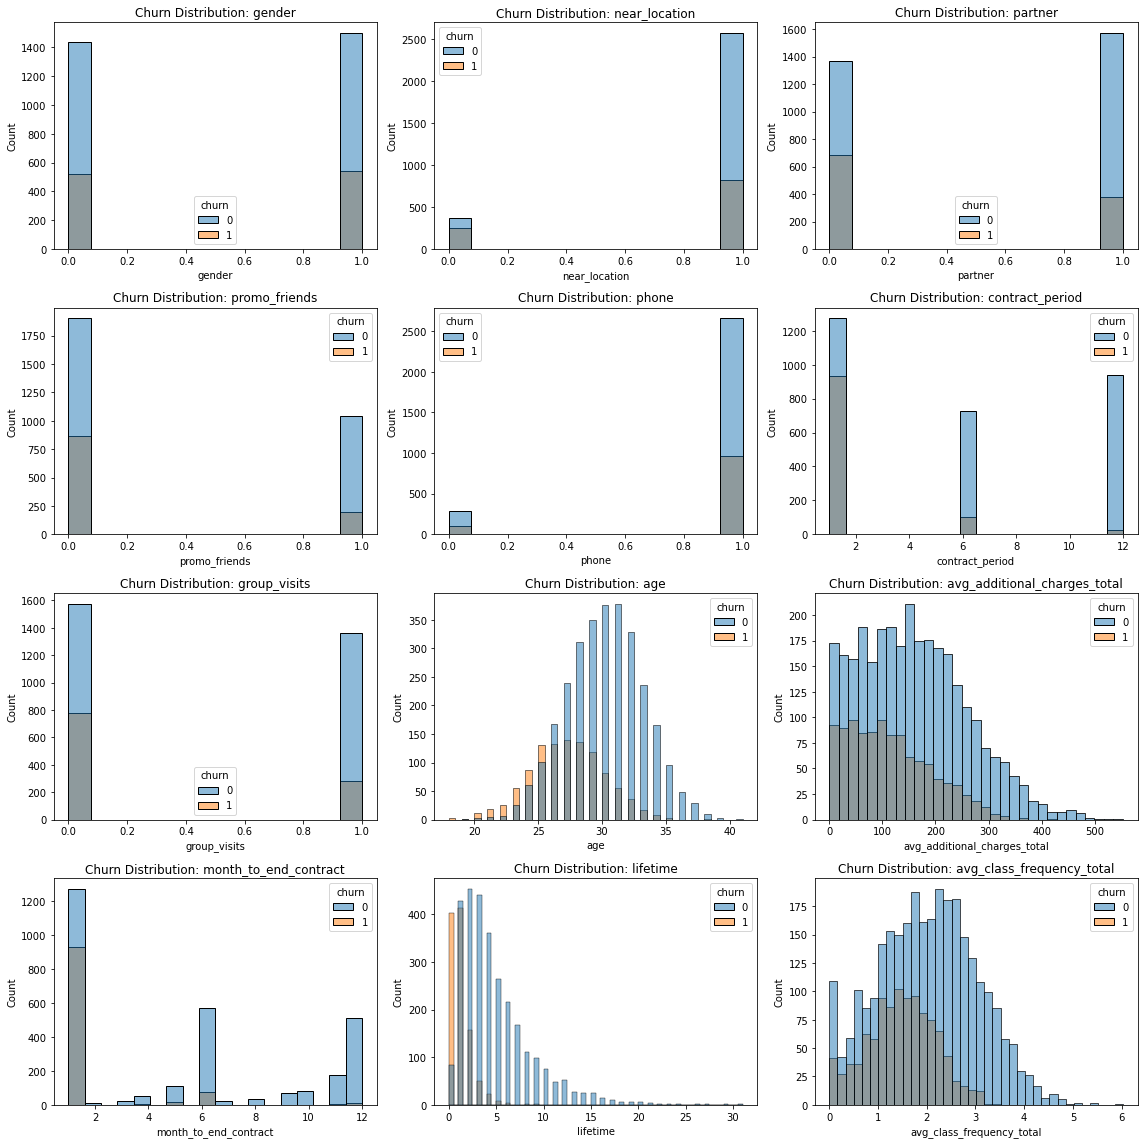

In [12]:
count=1
plt.subplots(figsize=(16, 16))
sns.color_palette("mako", as_cmap=True)
for i in mf.drop("churn",axis=1).columns:
    if count > 12:
        continue
    else:
        plt.subplot(4,3,count)
        plt.title('Churn Distribution: {}'.format(str(i)))
        sns.histplot(data=mf, x= i, hue="churn")
        count+=1
plt.tight_layout()
plt.show()

According to the graphs above we can draw some interesting conclusions:
<ul>
    <li>Age distribution: the peak of churn customers 25-27 years, the peak of staying customers 30-32 years.</li>
    <li>Month to end contract distribution: peak of churn 6 months, the peak of stay customers 1-2 months.</li>
    <li>Lifetime distribution: we can see a significant peak in the churn of visitors at 0 and 1 lifetime.</li>
    <li>Average frequency total distribution: there is no pronounced peak in the number of remaining users, the indicator varies frm 1 to 3 visits per week, there is also a large number of users visiting th gym 4 times a week, while the churn peak occurs at 1 to 2 visits per week.
    <li>More people who did not have partners churned over people with partners. Same for people with group visits</li>
    <li>The highest churn by internet service is accounted for users with contract period of one month and very low churn rate for users with contract of 12 months.</li>
</ul>

### Correlation matrix

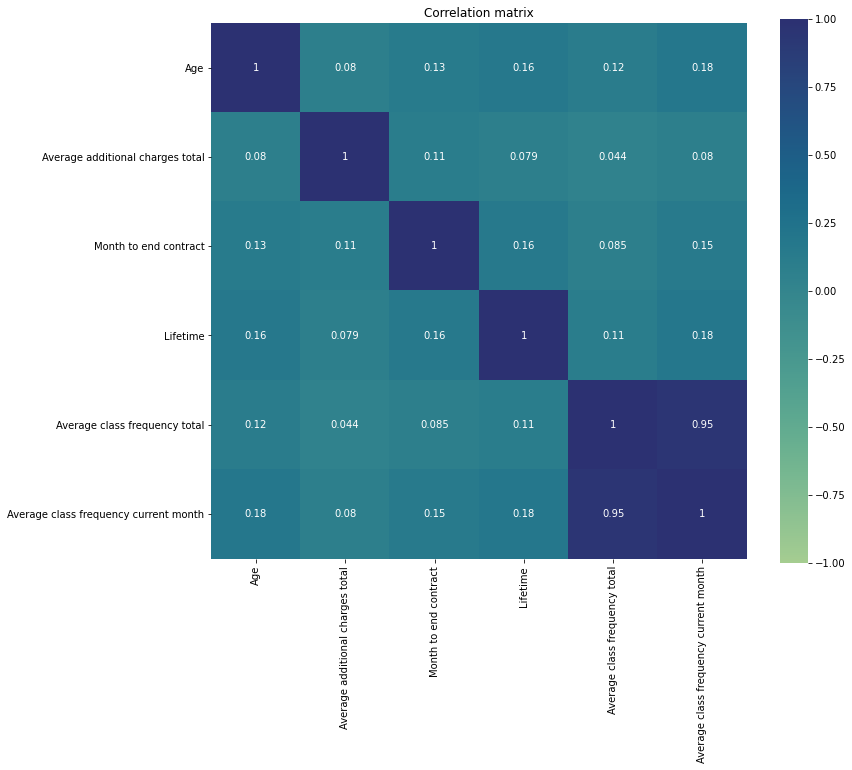

In [13]:
cm = mf[num_cols].corr()
cm.columns=['Age', 'Average additional charges total', 'Month to end contract', 'Lifetime', 'Average class frequency total', 'Average class frequency current month']
cm.index=['Age', 'Average additional charges total', 'Month to end contract', 'Lifetime', 'Average class frequency total', 'Average class frequency current month']
fig, ax = plt.subplots(figsize = (12, 14))

fig.set_size_inches(12,10)
ax.set_title('Correlation matrix')
sns.color_palette("magma", as_cmap=True)

sns.heatmap(cm, annot = True, square=True, vmin=-1, vmax=1, center= 0, cmap='crest')

plt.show()

The correlation matrix above shows a strong dependency between two features: Average class frequency total and Average class frequency current month, the features have a correlation of about 0.95 which indicates presence of multicollinearity between the two variables. I will therefore drop Average class frequency current month.

In [14]:
mf.drop(['avg_class_frequency_current_month'], axis=1, inplace= True)
mf_num.drop(['avg_class_frequency_current_month'], axis=1, inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Conclusion

On this part of the project we have described the typical client of the gym chain Model Fitness.  
We also divided the data into two groups: churn and stay, in order to understand how the averages of our features change. EDA analysis has been done specifically to see the distribution of features based on churn. Correlation among the features and target variable (churn) has been done; presence of multicollinearity in the data has been detected and dealt with. The data is ready for prediction and analysis.

## Step 3. Build a model to predict user churn

### Build a binary classification model for customers where the target feature is the user's leaving next month.

On this part of the project I'll divide the data into the train and validation sets using the train_test_split() function into 80% training and 20% validation. I will train the model on the train set with two methods: logistic regression and random forest. Lastly, I'll evaluate accuracy, precision, and recall for both models using the validation data, these metrics I'll use to compare the models and choose the model that gave better results.

In [15]:
#split data into train and validation sets

X = mf.drop('churn', axis=1)
y=mf['churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [16]:
#define function for calculation metrics

def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

### Logistic regression

In [17]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [18]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')

Metrics for logistic regression:
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77
	F1: 0.77
	ROC_AUC: 0.95


We make correct predictions for more then 90 % of answers, the values for all metrics, calculated according to our test are really high and this is an excellent result.

To throw more light on the model performance, I will visualise a confusion matrix for the logistic regression model.

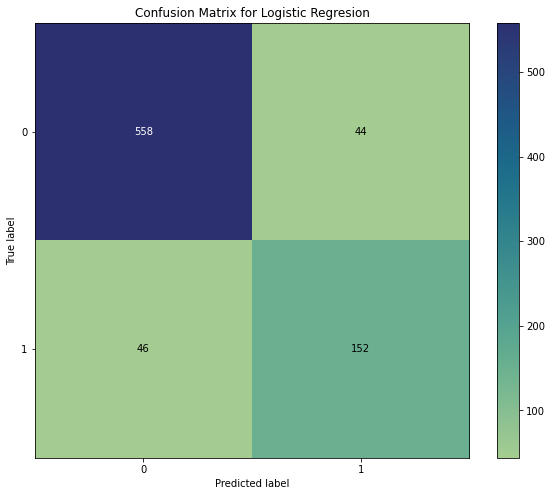

In [19]:
skplt.metrics.plot_confusion_matrix(y_test,lr_predictions,cmap='crest',figsize= (10,8), \
                                    title= "Confusion Matrix for Logistic Regresion")
plt.show()

Out of 602 non churn customers in the validation data, the model correctly predicted 558 of them (True positive), and wrongly predicted 44 of them (False negative or Type II error). Out of the 198 churn customers in the validation data, the model correctly predicted 152 (True negative), and wrongly predicted 46 of them (False positive or Type I error).

### Random forest

In [20]:
rf_model = RandomForestClassifier(random_state=0)

rf_model.fit(X_train,y_train)

rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.89
	Precision: 0.80
	Recall: 0.76
	F1: 0.78
	ROC_AUC: 0.94


Roc auc score is 0.97, so the models are strong, and the other metrics are also high.

To throw more light on the model performance, I will visualise a confusion matrix for the random forest model.

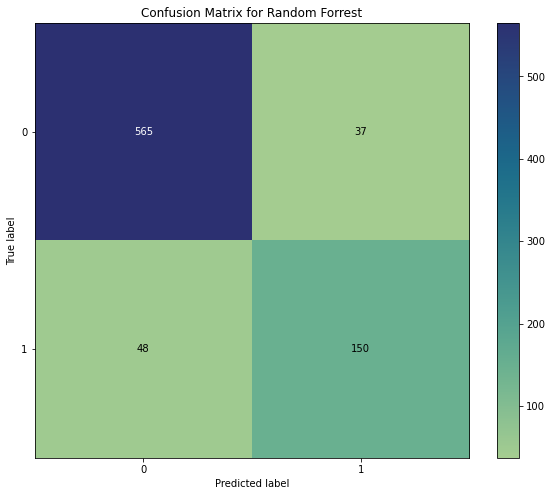

In [21]:
skplt.metrics.plot_confusion_matrix(y_test,rf_predictions,cmap='crest',figsize= (10,8), \
                                    title= "Confusion Matrix for Random Forrest")
plt.show()

### Conclusion

Our Random forest model performed a little bit better than the logistic regression by catching 92% of the true cases (91% using the logistic regression) in the unseen/validation set and had an ROC_AUC of 0.97 (0.96 using logistic regression). Its a good results, but since our logistic regression and random forest model perfomed more or less the same, It's a good idea to go with the simpler and more intepretable model that is the logistic regression for the choice of model.

## Step 4. Create user clusters

### Standardize the data

In [22]:
scaler = StandardScaler() # creating a scaler class object (normalizer)
x_sc = scaler.fit_transform(mf.drop(columns = ['churn']))

### Matrix of distances

In [23]:
linked = linkage(x_sc, method = 'ward')

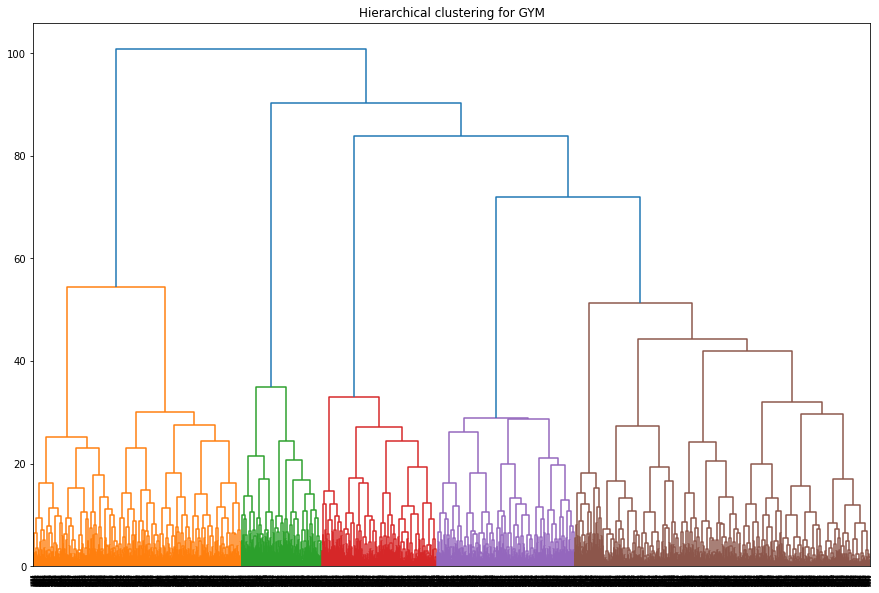

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show()

The suggested optimal number of clusters corresponds to the five different colors on the plot.

### Train the clustering model and predict customer clusters

In [25]:
# define the k_means model with 5 clusters
km = KMeans(n_clusters = 5, random_state=0)
# predict the clusters for observations
labels = km.fit_predict(x_sc)

mf['cluster_km'] = labels

In [26]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.16


Silhouette score around zero (0.14) indicate overlapping clusters, maybe it will be the higher score if we will split the model into the 5 clusters.

### The mean feature values for clusters

In [27]:
mf.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,0,4
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,0,1
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,0,4
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,0,2


In [28]:
# get the statistics of the mean feature values per cluster
churn_group_mean_num = mf.groupby(['cluster_km'])[num_cols].mean().reset_index()
print(churn_group_mean_num)

KeyError: "Columns not found: 'avg_class_frequency_current_month'"

Based on the observation above on average values of features broken down by clusters I want to mark 0 and 3 clusters, they have the highest rates of additional charges and average visit frequency (monthly and total). It means, that these groups include regular customers that bring the highest income to the gym. Cluster 3 have the high indicator of feature month to end contract, so likely they have contracts for 1 year. The most disadvantaged group is cluster 1.

In [ ]:
churn_group_mean_cat = mf.groupby(['cluster_km'])[cat_cols].mean().reset_index()
print(churn_group_mean_cat)

The metrics above represent customer profiles. It is worth highliting group 3, a rather clear profile clear out: the majority of users are employees of partner companies who recieve discounts on their contracts, this group also has the highest rate for a feature promo friend, group visits and the longest contract period. It is likely the most 'constant' cluster with the lowest churns, based an the analysis above, we see that most customers have contracts for a long term, and based on our analysis, the longer the term of the contract, the less churn. 

### Plot distributions of features for the clusters

I will select the continuous variables and plot their distributions with respect to clusters. I will leave out the features that are categorical. 

In [ ]:
count=1

plt.subplots(figsize=(12, 12))
for i in mf_num.drop(["churn", "cluster_km"],axis=1).columns:
    if count > 12:
        continue
    else:
        plt.subplot(2,2,count)
        sns.histplot(data = mf_num, x= i, hue="cluster_km", kde=True,  palette="crest")
        plt.title('Cluster Distribution: {}'.format(str(i)))
        count+=1
print("Distribution of Selected Features:")

plt.tight_layout()
plt.show()

The graphs above shows the distribution of features for the clusters
<ul>
    <l

### Churn rate for each cluster

In [ ]:
pivot_clusters = mf.pivot_table(index='cluster_km', values = 'churn', aggfunc=['sum', 'count'])
pivot_clusters.columns = ['Churn customers', 'Total customers']
pivot_clusters['Churn rate'] = pivot_clusters['Churn customers'] / pivot_clusters['Total customers']
pivot_clusters.sort_values(by='Churn rate', ascending=False)

The table above shows the churn rate for each cluster. We see the lowest churn rates among customers who are in clusters 0 and 3. 

In [ ]:
df_plot = mf.groupby('lifetime').churn.mean().reset_index()
plot_data = [
    go.Scatter(
        x=df_plot['lifetime'],
        y=df_plot['churn'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           ),
    )
]
plot_layout = go.Layout(
        yaxis= {'title': "Churn Rate"},
        xaxis= {'title': "Lifetime"},
        title='Lifetime vs Churn rate',
        plot_bgcolor  = "rgb(243,243,243)",
        paper_bgcolor  = "rgb(243,243,243)",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The plot above shows us the mean churn rate of customers by lifetime. The highest churn rate is on the lifetime 0. Therefore, we need to make some changes to the gym policy to retain customers in the very early stages and motivate them to stay with us.

### Conclusion

On this step of the project we standardized our data, predicted and splitted the users by clusters based on dendrogram and k-means algorithm, studied the mean values of features and calculated the churn rates of clusters. Let's draw the helpful conclusions on the next step.

## Conclusions and basic recommendations on working with customers

Based on the above research, I have developed some suggestions and recommendations.
<ul>  
    <li>First of all, I want to note the large churn of clients with contracts for one month and who leave the gym and no longer return after a few sessions.  there is a need to create an interest in continuing to use the gym services and motivational policies in order for them to renew their contracts.  for this purpose, I propose to create user cards with the possibility of accumulating points and subsequently exchanging these points for rewards.  for example, additional services of the gym (cafe, swimming pool, etc.), free classes or master classes.</li>
    <li>My next suggestion is to offer promotions and discounts for those who renew the contract.  As we noticed in our research, we have the lowest customer churn for that group of customers who signed a contract for a year, therefore, we need to strive to ensure that users switch from short-term to long-term contracts</li>
    <li>Creating a feedback system for improving gym services and eliminate deficiences, especially feedback from users who decide to leave the gym. We need to ask them their reasons for leaving, suggestions they have and what we can do to get them to stay.</li>
    <li>Membership freeze. This option will help us to return customers who temporarily can not to visit the gym, but which are planning to return in the feature. In this way we will become more customer-oriented, and it will give us an advantage over other gyms.</li>
</ul>